In [15]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pickle
import copy


In [16]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1') # Nxd(3072) (Nx (32x32x3))
        X = np.transpose(dataset['data'] / 255.) # d x N
        mean_X = np.mean(X, axis=1) # mean of each row (each feature mean)
        std_X = np.std(X, axis=1)
        X = X - np.matlib.repmat(mean_X, X.shape[1], 1).T
        X = np.divide(X, np.matlib.repmat(std_X, X.shape[1], 1).T)
        
        y = np.array(dataset['labels'])
        Y = np.transpose(np.eye(X.shape[1], np.max(y) + 1)[y]) # K x N
        return X, Y, y

def load_all(validation_size):
    X_1, Y_1, y_1 = load_batch('data/data_batch_1')
    X_2, Y_2, y_2 = load_batch('data/data_batch_2')
    X_3, Y_3, y_3 = load_batch('data/data_batch_3')
    X_4, Y_4, y_4 = load_batch('data/data_batch_4')
    X_5, Y_5, y_5 = load_batch('data/data_batch_5')
    
    X = np.concatenate((X_1, X_2, X_3, X_4, X_5[:,:-validation_size]), axis=1)
    Y = np.concatenate((Y_1, Y_2, Y_3, Y_4, Y_5[:,:-validation_size]), axis=1)
    y = np.concatenate((y_1, y_2, y_3, y_4, y_5[:-validation_size]))
    
    X_valid = X_5[:,-validation_size:]
    Y_valid = Y_5[:,-validation_size:]
    y_valid = y_5[-validation_size:]
    return X, Y, y, X_valid, Y_valid, y_valid
    

In [44]:
def batch_normalize(scores, mean, variance):
#     return np.dot(np.power(np.diag(variance) + 1e-9, -0.5), (scores - np.array([mean])))
    return (scores - mean.reshape((-1,1))) / np.sqrt(variance.reshape((-1,1)) + 1e-9)

In [71]:
def softmax(s):
    exponent = np.exp(s)
    return np.divide(exponent, np.sum(exponent, axis=0))

def evaluate_classifier(X, layers, batch_norm=False, precomp=False):
    num_layers = len(layers)
    H = []
    S = []
    S_norm = []
    
    layer_means = []
    layer_variances = []
    
    gammas = []
    betas = []
    
    h_prev = X
    
    for i, layer in enumerate(layers):
        if i == num_layers - 1:  # If last layer
            P = softmax(np.dot(layer["W"], h_prev) + layer["b"]) # K x N
            
            if batch_norm:
                return H, P, S, S_norm, np.array(layer_means), np.array(layer_variances), gammas, betas
            else:
                return H, P
        else:
            s = np.dot(layer["W"], h_prev) + layer["b"] # m x N
            
            if batch_norm:
                S.append(s)
                
                if precomp:
                    print("USING PRECOMPUTED MEANS")
                    mean = layer["mean"]
                    variance = layer["var"]
                    print(mean)
                else:
                    mean = np.mean(s, axis=1) # m len
#                     variance = np.mean(np.square(s - np.array([mean]).transpose()), axis=1) # m
                    variance = np.var(s, axis=1)
                    layer_means.append(mean)
                    layer_variances.append(variance)

                gamma = layer["gamma"]
                beta = layer["beta"]
                
                gammas.append(gamma)
                betas.append(beta)
                
                normalized = batch_normalize(s, mean, variance)
                S_norm.append(normalized)
                
                transformed = np.multiply(gamma, normalized) + beta
                h = np.maximum(transformed, 0)
                H.append(h)
                h_prev = h
            else:
                h = np.maximum(s, 0) # ReLU; m x N
                H.append(h)
                h_prev = h

In [19]:
def batch_norm_backpass(G, S, mean, variance, Nb):
    sigma_1 = np.array([np.power(v + 1e-9,-0.5) for v in variance]).reshape((-1,1))
    sigma_2 = np.array([np.power(v + 1e-9,-1.5) for v in variance]).reshape((-1,1))
    
    G_1 = np.multiply(G, np.dot(sigma_1, np.ones((Nb, 1)).T))
    G_2 = np.multiply(G, np.dot(sigma_2, np.ones((Nb, 1)).T))
    D = S - (np.dot(mean.reshape((-1,1)), np.ones((Nb, 1)).T))

    c = np.multiply(G_2, D)
    c = np.dot(c, np.ones((Nb, 1)))
    
    res = G_1 - np.divide(np.dot(np.dot(G_1, np.ones((Nb, 1))), np.ones((Nb, 1)).T), Nb) 
    res = res - np.divide(np.multiply(D, np.dot(c, np.ones((Nb, 1)).T)), Nb)
    return res

In [73]:
def compute_cost(X, Y, layers, lmb, batch_norm=False, precomp=False):
    H, P = evaluate_classifier(X, layers, batch_norm, precomp)[:2]
    n = np.sum(np.multiply(Y, P), axis=0)
    cross_entropy = np.sum(-np.log(n))
    
    w_square_sum = 0
    if lmb > 0:
        for layer in layers:
            w_square_sum += np.sum(np.diag(np.dot(layer["W"].T, layer["W"])))
    return (cross_entropy / X.shape[1]) + (lmb * w_square_sum)

def compute_gradients(X, Y, layers, lmb, batch_norm, average_mean=None, average_variance=None):
    if batch_norm:
        H, P, S, S_norm, layer_means, layer_variances, gammas, betas = evaluate_classifier(X, layers, batch_norm)
    else:
        H, P = evaluate_classifier(X, layers)

    G = -(Y - P) # through loss and softmax
    Nb = X.shape[1] # batch size
    
    W_gradients = []
    b_gradients = []
    
    if batch_norm:
        gamma_gradients = []
        beta_gradients = []
        alpha = 0.9
        if average_mean is None and average_variance is None:
            average_mean = layer_means
            average_variance = layer_variances
        else:
            average_mean = (alpha * average_mean) + ((1. - alpha) * layer_means)
            average_variance = (alpha * average_variance) + ((1. - alpha) * layer_variances)
        
        for i, layer in reversed(list(enumerate(layers))): # from last to first
            if batch_norm and i == len(layers) - 1: # last
                grad_W = np.divide(np.dot(G, H[i - 1].T), Nb) + (2 * lmb * layer["W"]) # J w.r.t W_k
                grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb) # J w.r.t b_k
                G = np.dot(layer["W"].T, G)
                G = G * (H[i - 1] > 0).astype(int) # element-wise
            else:
                mp = np.multiply(G, S_norm[i])
                gamma_grad = np.dot(np.divide(mp, Nb), np.ones((Nb, 1))) # J w.r.t gamma
                print(gamma_grad.shape)
                beta_grad = np.divide(np.dot(G, np.ones((Nb, 1))), Nb) # J w.r.t beta
                print(beta_grad.shape)
                
                gamma_gradients.append(gamma_grad)
                beta_gradients.append(beta_grad)

                G = np.multiply(G, gammas[i] * np.ones((Nb, 1)).T) # eq.26

                G = batch_norm_backpass(G, S[i], layer_means[i], layer_variances[i], Nb)

                if i > 0: # prop back if not first
                    grad_W = np.divide(np.dot(G, H[i - 1].T), Nb) + (2 * lmb * layer["W"]) # J w.r.t W_k
                    grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb) # J w.r.t b_k
                    G = np.dot(layer["W"].T, G)
                    G = G * (H[i - 1] > 0).astype(int) # element-wise
                else: # first
                    grad_W = np.divide(np.dot(G, X.T), Nb) + (2 * lmb * layer["W"]) # J w.r.t W_k
                    grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb) # J w.r.t b_k

            W_gradients.append(grad_W)
            b_gradients.append(grad_b)
            
        return W_gradients, b_gradients, gamma_gradients, beta_gradients, average_mean, average_variance
    else:
        for i, layer in reversed(list(enumerate(layers))): # from last to first
            if i > 0:
                grad_W = np.divide(np.dot(G, H[i - 1].T), Nb) + (2 * lmb * layer["W"]) # J w.r.t W_k
                grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb) # J w.r.t b_k
                G = np.dot(layer["W"].T, G)
                G = G * (H[i - 1] > 0).astype(int) # element-wise

                W_gradients.append(grad_W)
                b_gradients.append(grad_b)
            else: # first layer
                grad_W = np.divide(np.dot(G, X.T), Nb) + (2 * lmb * layer["W"])
                grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb)
                W_gradients.append(grad_W)
                b_gradients.append(grad_b)
    
        return W_gradients, b_gradients


In [21]:
def compute_accuracy(X, y, layers, batch_norm=False, precomp=False):
    _, p = evaluate_classifier(X, layers, batch_norm, precomp)[:2]
    argmax = np.argmax(p, axis=0) # max element index of each column
    diff = argmax - y
    return (diff == 0).sum() / X.shape[1]

In [22]:
def mini_batch_GD(X, Y, GDparams, layers, lmb, validation, batch_norm=False, calculate_loss=False):
#     print("Training samples: {}".format(X.shape[1]))
#     print("Validation samples: {}".format(validation["X"].shape[1]))
#     print("Training parameters: ", GDparams)
    J_training = []
    J_validation = []
    
    eta_diff = GDparams["eta_max"] - GDparams["eta_min"]
    eta = GDparams["eta_min"]
    t = 0 # step
    l = 0 # cycle
    
    average_mean = None
    average_variance = None
    
    runs_in_epoch = int(X.shape[1] / GDparams["n_batch"])
    # for epoch in range(GDparams["epochs"]):
    while l < GDparams["max_cycles"]:
        for j in range(1, runs_in_epoch):
            j_start = (j - 1) * GDparams["n_batch"]
            j_end = j * GDparams["n_batch"]
            
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]
            
            if batch_norm:
                grad_W, grad_b, gamma_grad, beta_grad, average_mean, average_variance = compute_gradients(X_batch, Y_batch, layers, lmb, batch_norm, average_mean, average_variance)
            else: 
                grad_W, grad_b = compute_gradients(X_batch, Y_batch, layers, lmb, batch_norm=False)
            
            for i, layer in enumerate(layers):
                layer["W"] = layer["W"] - (eta * grad_W[-1 - i])
                layer["b"] = layer["b"] - (eta * grad_b[-1 - i])
                
                if batch_norm and i != len(layers) - 1:
                    layer["gamma"] = layer["gamma"] - (eta * gamma_grad[-1 - i])
                    layer["beta"] = layer["beta"] - (eta * beta_grad[-1 - i])
                    layer["mean"] = average_mean[i]
                    layer["var"] = average_variance[i]
        
            if calculate_loss and t % 100 == 0:
                J_training.append(compute_cost(X, Y, layers, lmb, batch_norm, precomp=False))
                J_validation.append(compute_cost(validation["X"], validation["Y"], layers, lmb, batch_norm, precomp=False))
                print("Step {}, training loss: {}".format(t, J_training[-1]))
                
            t += 1 # next update step
            if t % (2 * GDparams["n_s"]) == 0:
                l += 1 # next cycle
                if l == GDparams["max_cycles"]:
                    break
                print("Entering cycle {}, t: {}, eta: {}".format(l, t, eta))
            if t <= (2*l + 1) * GDparams["n_s"]:
                eta = GDparams["eta_min"] + (eta_diff * ((t - (2 * l * GDparams["n_s"])) / GDparams["n_s"]))
            else:
                eta = GDparams["eta_max"] - (eta_diff * (t - ((2*l + 1) * GDparams["n_s"])) / GDparams["n_s"])
        
        print("NEXT EPOCH")
        # shuffle the data after each epoch
        shuffled_order = np.random.permutation(X.shape[1])
        X = np.take(X, shuffled_order, axis=1)
        Y = np.take(Y, shuffled_order, axis=1)

    if calculate_loss:
        return layers, J_training, J_validation
    else:
        return layers

In [75]:
# X, Y, y = load_batch('data/data_batch_1')
# X_valid, Y_valid, y_valid = load_batch('data/data_batch_2')
X, Y, y, X_valid, Y_valid, y_valid = load_all(validation_size=5000)
X_test, Y_test, y_test = load_batch('data/test_batch')

d = X.shape[0]
N = X.shape[1]
K = Y.shape[0]

# X: d x N
# Y: K x N

# m = 50 # hidden units

# std_dev_1 = 1 / np.sqrt(d)
# std_dev_2 = 1 / np.sqrt(m)
# W_1 = std_dev * np.random.randn(m, d)
# b_1 = std_dev * np.random.randn(m, 1)

# W_2 = std_dev * np.random.randn(K, m)
# b_2 = std_dev * np.random.randn(K, 1)
def init_network(dimensions=d, num_layers=2, hidden_units=[50], classes=K):
    
    layers = [
        {
            "W": (1 / np.sqrt(dimensions)) * np.random.randn(hidden_units[0], dimensions),
            "b": np.zeros((hidden_units[0], 1)),
            "gamma": np.ones((hidden_units[0], 1)),
            "beta": np.zeros((hidden_units[0], 1)),
        }
    ]
    
    if len(hidden_units) > 1:
        for prev_i, m in enumerate(hidden_units[1:]):
            layers.append({
                "W": (1 / np.sqrt(hidden_units[prev_i])) * np.random.randn(m, hidden_units[prev_i]),
                "b": np.zeros((m, 1)),
                "gamma": np.ones((m, 1)),
                "beta": np.zeros((m, 1)),
            })
        
    layers.append({
            "W": (1 / np.sqrt(hidden_units[num_layers-2])) * np.random.randn(classes, hidden_units[num_layers-2]),
            "b": np.zeros((K, 1)),
        })
    
    return layers


# lmb = 0.01  # lambda
# lmb = np.power(10, -2.325238114712273)
lmb = 0.005
GDparams = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 2250,
    "epochs": 20,
    "max_cycles": 2,
}
#     "n_s": 2 * np.floor(X.shape[1] / 100),
validation = {
    "X": X_valid,
    "Y": Y_valid,
}

print(GDparams)

{'n_batch': 100, 'eta_min': 1e-05, 'eta_max': 0.1, 'n_s': 2250, 'epochs': 20, 'max_cycles': 2}


In [76]:
def compute_gradients_num(X, Y, layers, lmb, h):
    
    grad_W = [np.zeros(layer["W"].shape) for layer in layers]
    grad_b = [np.zeros(layer["W"].shape[0]) for layer in layers]
    c = compute_cost(X, Y, layers, lmb)
    
    for l, layer in enumerate(layers):
        for i in range(len(layer["b"])):
            layers_try = copy.deepcopy(layers)
            layers_try[l]["b"][i] = layers_try[l]["b"][i] + h
            c2 = compute_cost(X, Y, layers_try, lmb)
            grad_b[l][i] = (c2 - c) / h

        W_shape = layer["W"].shape
        for i in range(W_shape[0]):
            for j in range(W_shape[1]):
                layers_try = copy.deepcopy(layers)
                layers_try[l]["W"][i,j] = layers_try[l]["W"][i,j] + h
                c2 = compute_cost(X, Y, layers_try, lmb)
                grad_W[l][i,j] = (c2 - c) / h
        
    return grad_W, grad_b

def compute_gradients_num_slow(X, Y, layers, lmb, h, batch_norm=False):
    
    grad_W = [np.zeros(layer["W"].shape) for layer in layers]
    grad_b = [np.zeros(layer["b"].shape[0]) for layer in layers]
    grad_gamma = []
    grad_beta = []

    for l, layer in enumerate(layers):
        for i in range(len(layer["b"])):
            layers_try1 = copy.deepcopy(layers)
            layers_try2 = copy.deepcopy(layers)                                       
                                       
            layers_try1[l]["b"][i] = layers_try1[l]["b"][i] - h
            c1 = compute_cost(X, Y, layers_try1, lmb, batch_norm)
            
            
            layers_try2[l]["b"][i] = layers_try2[l]["b"][i] + h
            c2 = compute_cost(X, Y, layers_try2, lmb, batch_norm)
            
            grad_b[l][i] = (c2 - c1) / (2*h)
        
        W_shape = layer["W"].shape 
        for i in range(W_shape[0]):
            for j in range(W_shape[1]):
                layers_try1 = copy.deepcopy(layers)
                layers_try2 = copy.deepcopy(layers) 

                layers_try1[l]["W"][i,j] = layers_try1[l]["W"][i,j] - h
                c1 = compute_cost(X, Y, layers_try1, lmb, batch_norm)
                
                layers_try2[l]["W"][i,j] = layers_try2[l]["W"][i,j] + h
                c2 = compute_cost(X, Y, layers_try2, lmb, batch_norm)
                grad_W[l][i,j] = (c2 - c1) / (2*h)
                
        if batch_norm and l is not len(layers) - 1:
            for i in range(layer["gamma"].shape[0]):
                layers_try_gamma1 = copy.deepcopy(layers)
                layers_try_gamma2 = copy.deepcopy(layers)
                
                layers_try_gamma1[l]["gamma"][i] = layers_try_gamma1[l]["gamma"][i] - h
                c1 = compute_cost(X, Y, layers_try_gamma1, lmb, batch_norm)

                layers_try_gamma2[l]["gamma"][i] = layers_try_gamma2[l]["gamma"][i] + h
                c2 = compute_cost(X, Y, layers_try_gamma2, lmb, batch_norm)

                grad_gamma.append((c2 - c1) / (2*h))
                
            for i in range(layer["beta"].shape[0]):                
                layers_try_beta1 = copy.deepcopy(layers)
                layers_try_beta2 = copy.deepcopy(layers)

                layers_try_beta1[l]["beta"][i] = layers_try_beta1[l]["beta"][i] - h
                c1 = compute_cost(X, Y, layers_try_beta1, lmb, batch_norm)

                layers_try_beta2[l]["beta"][i] = layers_try_beta2[l]["beta"][i] + h
                c2 = compute_cost(X, Y, layers_try_beta2, lmb, batch_norm)

                grad_beta.append((c2 - c1) / (2*h))
            
    
    return grad_W, grad_b, grad_gamma, grad_beta

In [81]:
feature_dims = 10
samples = 2

layers_g = init_network(dimensions=feature_dims, num_layers=2, hidden_units=[50], classes=K)
X_g = X[0:feature_dims, 0:samples] #d X N
Y_g = Y[:, 0:samples] #K x N

grad_W, grad_b, grad_gamma, grad_beta = compute_gradients(X_g, Y_g, layers_g, lmb=0, batch_norm=True)[:4]
ngrad_w, ngrad_b, ngrad_gamma, ngrad_beta = compute_gradients_num_slow(X_g, Y_g, layers_g, lmb=0, h=1e-6, batch_norm=True)
print("\ngrad b (last to first):")


for i in range(len(grad_b)):
    diffs = np.abs(grad_b[len(grad_b) - 1 - i].T - ngrad_b[i]) / np.maximum(1e-6, np.abs(grad_b[len(grad_b) - 1 - i].T) + np.abs(ngrad_b[i]))
#     print(diffs)
    print("Layer {} mean diff: {}".format(len(grad_b) - i, np.mean(diffs)))


print("\ngrad W (last to first):")
for i in range(len(grad_W)):
    diffs = np.abs(grad_W[len(grad_W) - 1 - i] - ngrad_w[i]) / np.maximum(1e-6, np.abs(grad_W[len(grad_W) - 1 - i]) + np.abs(ngrad_w[i]))
#     print(diffs)
    print("Layer {} mean diff: {}".format(len(grad_W) - i, np.mean(diffs)))
    
print("\ngrad gamma (last to first):")
for i in range(len(grad_gamma)):
    print(grad_gamma[i])
    print(ngrad_gamma[i])
#     print(np.abs(grad_gamma[len(grad_gamma) - 1 - i] - ngrad_gamma[i]))
    diffs = np.abs(grad_gamma[len(grad_gamma) - 1 - i] - ngrad_gamma[i]) / np.maximum(1e-6, np.abs(grad_gamma[len(grad_gamma) - 1 - i]) + np.abs(ngrad_gamma[i]))
#     print(diffs)
    print("Layer {} mean diff: {}".format(len(grad_gamma) - i, np.mean(diffs)))
    
print("\ngrad beta (last to first):")
for i in range(len(grad_beta)):
    diffs = np.abs(grad_beta[len(grad_beta) - 1 - i] - ngrad_beta[i]) / np.maximum(1e-6, np.abs(grad_beta[len(grad_beta) - 1 - i]) + np.abs(ngrad_beta[i]))
#     print(diffs)
    print("Layer {} mean diff: {}".format(len(grad_beta) - i, np.mean(diffs)))


(50, 1)
(50, 1)

grad b (last to first):
Layer 2 mean diff: 4.4415337380199205e-06
Layer 1 mean diff: 5.939191245298004e-10

grad W (last to first):
Layer 2 mean diff: 0.0001244175541816699
Layer 1 mean diff: 1.4062122794891166e-09

grad gamma (last to first):
[[ 5.57934219e-02]
 [-1.29358133e-02]
 [ 1.43291626e-01]
 [-1.01760155e-01]
 [ 9.53168627e-02]
 [ 8.41427014e-03]
 [ 2.35437675e-02]
 [ 1.49132939e-01]
 [-9.13131664e-03]
 [-1.26705228e-02]
 [-9.46918551e-02]
 [-8.20661553e-02]
 [-1.11485762e-02]
 [ 5.80210361e-02]
 [ 3.28562217e-02]
 [ 5.15663765e-03]
 [ 1.37919205e-01]
 [-1.37193385e-04]
 [ 1.52086905e-01]
 [ 6.24893599e-02]
 [ 4.79028003e-02]
 [ 1.23719306e-01]
 [-7.47050509e-03]
 [ 3.11202225e-02]
 [ 7.08140152e-02]
 [ 2.98453996e-02]
 [ 5.58220039e-02]
 [ 3.56437429e-02]
 [-4.24276471e-02]
 [-4.33454809e-02]
 [ 7.30562013e-02]
 [ 6.67411670e-02]
 [-3.15647925e-02]
 [-3.86977917e-02]
 [ 7.02650538e-02]
 [-5.10252055e-02]
 [-4.86599253e-02]
 [ 1.57259847e-01]
 [ 1.41474166e-01

In [29]:
# 3-layers
layers = init_network(num_layers=3, hidden_units=[50,50])
layers_trained, J_training, J_validation = mini_batch_GD(X, Y, GDparams, layers, lmb, validation, calculate_loss=True)
test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
test_acc = compute_accuracy(X_test, y_test, layers_trained)

Step 0, training loss: 3.0542220026379714
Step 100, training loss: 2.78145366654734
Step 200, training loss: 2.5451962796101353
Step 300, training loss: 2.3759652804678355
Step 400, training loss: 2.2757495780527375
NEXT EPOCH
Step 500, training loss: 2.207150353337256
Step 600, training loss: 2.1376165428219625
Step 700, training loss: 2.088212582559587
Step 800, training loss: 2.032389720513683
NEXT EPOCH
Step 900, training loss: 1.9769404255721215
Step 1000, training loss: 1.935790832459436
Step 1100, training loss: 1.9117730856625768
Step 1200, training loss: 1.8630613147063986
Step 1300, training loss: 1.834305742731938
NEXT EPOCH
Step 1400, training loss: 1.838208935484769
Step 1500, training loss: 1.7766065564805396
Step 1600, training loss: 1.7445709195067787
Step 1700, training loss: 1.7179420727662922
NEXT EPOCH
Step 1800, training loss: 1.727649062942914
Step 1900, training loss: 1.7439609853975477
Step 2000, training loss: 1.6430130474969977
Step 2100, training loss: 1.6398

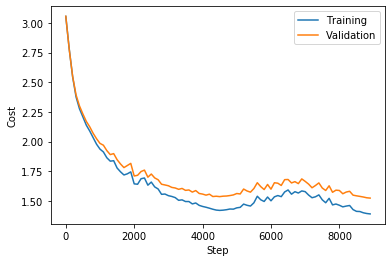

Test cost:  1.5317799786685302
Test accuracy:  0.5328


In [30]:
plt.figure(0)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.plot([step*100 for step in range(len(J_training))], J_training, label="Training")
plt.plot([step*100 for step in range(len(J_validation))], J_validation, label="Validation")
plt.legend()
plt.show()

print("Test cost: ", test_cost)
print("Test accuracy: ", test_acc)

In [34]:
layers9 = init_network(num_layers=9, hidden_units=[50,30,20,20,10,10,10,10])
layers9_trained, J_training9, J_validation9 = mini_batch_GD(X, Y, GDparams, layers9, lmb, validation, calculate_loss=True)
test_cost9 = compute_cost(X_test, Y_test, layers9_trained, lmb)
test_acc9 = compute_accuracy(X_test, y_test, layers9_trained)

Step 0, training loss: 3.1584437575891635
Step 100, training loss: 3.1520614680715346
Step 200, training loss: 3.135819936693884
Step 300, training loss: 3.1078112771470674
Step 400, training loss: 3.0513730506310366
NEXT EPOCH
Step 500, training loss: 2.9738315667729203
Step 600, training loss: 2.8947909573295187
Step 700, training loss: 2.815551135262776
Step 800, training loss: 2.7375363189368795
NEXT EPOCH
Step 900, training loss: 2.6682975980317423
Step 1000, training loss: 2.597804857393734
Step 1100, training loss: 2.528872282762256
Step 1200, training loss: 2.4643585054350123
Step 1300, training loss: 2.407973198316094
NEXT EPOCH
Step 1400, training loss: 2.3704668797249475
Step 1500, training loss: 2.34997800833626
Step 1600, training loss: 2.3062409295931334
Step 1700, training loss: 2.2353427434335025
NEXT EPOCH
Step 1800, training loss: 2.208537533399923
Step 1900, training loss: 2.1616591000697443
Step 2000, training loss: 2.143648523774099
Step 2100, training loss: 2.1324

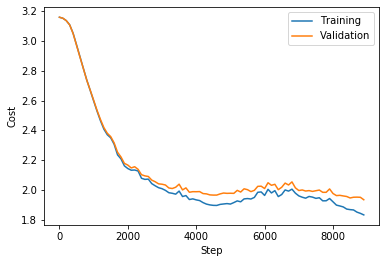

Test cost:  1.921850470281229
Test accuracy:  0.3276


In [35]:
plt.figure(0)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.plot([step*100 for step in range(len(J_training9))], J_training9, label="Training")
plt.plot([step*100 for step in range(len(J_validation9))], J_validation9, label="Validation")
plt.legend()
plt.show()

print("Test cost: ", test_cost9)
print("Test accuracy: ", test_acc9)

In [95]:
# 2-layers NON BN
layers = init_network(num_layers=2, hidden_units=[50])
print("Layer shapes:")
for l in layers:
    print(l["W"].shape)
print("---")
layers_trained, J_training, J_validation = mini_batch_GD(X, Y, GDparams, layers, lmb, validation, batch_norm=False, calculate_loss=True)
test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
test_acc = compute_accuracy(X_test, y_test, layers_trained)

Layer shapes:
(50, 3072)
(10, 50)
---
(10, 50)
(10, 50)
Step 0, training loss: 2.819795792204788
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10, 50)
(10

KeyboardInterrupt: 

In [27]:
# 2-layers
layers = init_network(num_layers=9, hidden_units=[50,30,20,20,10,10,10,10])
print("Layer shapes:")
for l in layers:
    print(l["W"].shape)
print("---")
layers_trained, J_training, J_validation = mini_batch_GD(X, Y, GDparams, layers, lmb, validation, batch_norm=True, calculate_loss=True)


test_cost = compute_cost(X_test, Y_test, layers_trained, lmb, batch_norm=True, precomp=True)
test_acc = compute_accuracy(X_test, y_test, layers_trained, batch_norm=True, precomp=True)

Layer shapes:
(50, 3072)
(30, 50)
(20, 30)
(20, 20)
(10, 20)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
---
Step 0, training loss: 3.4108786575080767
Step 100, training loss: 3.2819138709793156
Step 200, training loss: 3.172850335253418
Step 300, training loss: 3.0311697457955322
Step 400, training loss: 2.936101175313134
NEXT EPOCH
Step 500, training loss: 2.8494701610137785
Step 600, training loss: 2.768144329592506
Step 700, training loss: 2.687285562412945
Step 800, training loss: 2.6138018013165567
NEXT EPOCH
Step 900, training loss: 2.532482768636704
Step 1000, training loss: 2.4573556343431138
Step 1100, training loss: 2.378694345533178
Step 1200, training loss: 2.3027683359119524
Step 1300, training loss: 2.232687054015529
NEXT EPOCH
Step 1400, training loss: 2.163947268988898
Step 1500, training loss: 2.1215493181216214
Step 1600, training loss: 2.049600149832533
Step 1700, training loss: 2.036013704412895
NEXT EPOCH
Step 1800, training loss: 1.9677067781183066
Step 1900, training lo

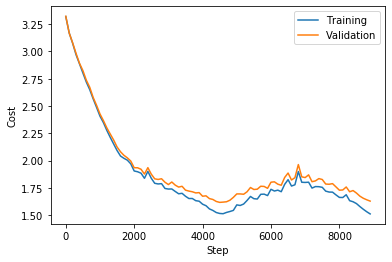

Test cost:  1.6235918723568925
Test accuracy:  0.4991


In [189]:
plt.figure(0)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.plot([step*100 for step in range(len(J_training))], J_training, label="Training")
plt.plot([step*100 for step in range(len(J_validation))], J_validation, label="Validation")
plt.legend()
plt.show()

print("Test cost: ", test_cost)
print("Test accuracy: ", test_acc)

In [162]:
print(layers[1])

{'W': array([[-0.01538028,  0.03797142, -0.05959421, ...,  0.0404259 ,
         0.03262774, -0.03571147],
       [ 0.01921223,  0.0408635 , -0.01719921, ..., -0.08768962,
         0.02070206, -0.02417298],
       [ 0.00243656, -0.06825153,  0.01091312, ..., -0.01290415,
         0.0425736 , -0.01299054],
       ...,
       [-0.00488379, -0.02837137, -0.02689171, ...,  0.02915828,
         0.01987113, -0.04700942],
       [-0.02499191, -0.03482578, -0.0376398 , ..., -0.02710248,
        -0.05809933, -0.04310897],
       [-0.00771295, -0.00076351,  0.00250044, ..., -0.05280703,
        -0.04770042, -0.03610853]]), 'b': array([[ 4.05132856e-18],
       [ 2.98601127e-17],
       [-1.19772560e-17],
       [ 5.73198104e-17],
       [-5.79452409e-18],
       [ 1.21780244e-17],
       [-4.60820682e-17],
       [ 1.72943437e-17],
       [-6.64495508e-17],
       [ 1.09350553e-17],
       [ 1.12145077e-16],
       [-3.28604680e-17],
       [-3.05320030e-17],
       [ 1.03653813e-16],
       [ 1.